<a href="https://colab.research.google.com/github/kustovass/detection-of-key-points-of-the-human-skeleton/blob/main/key_points_YOLOv7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение ключевых точек скелета человека с использованием предобученной модели YOLOv7



### Импорт библиотек и модулей

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git


Cloning into 'yolov7'...
remote: Enumerating objects: 1185, done.
remote: Total 1185 (delta 0), reused 0 (delta 0), pack-reused 1185
Receiving objects: 100% (1185/1185), 74.22 MiB | 16.89 MiB/s, done.
Resolving deltas: 100% (511/511), done.


In [ ]:
%cd yolov7/
!pip install -r requirements.txt

In [6]:
import requests
WEIGHTS_URL = 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt'
open("yolov7-w6-pose.pt", "wb").write(requests.get(WEIGHTS_URL).content)

161114789

In [7]:
import cv2
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

from models.experimental import attempt_load
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt, xywh2xyxy
from utils.plots import output_to_keypoint, plot_one_box

import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# path to images files for inference
TEST_IMGS_PATH = 'images/'
# path to yolov7-pose pretrained model
POSE_WEIGHTS = 'weights/yolov7-w6-pose.pt'

### Функции отображения результатов на изображении

In [ ]:
# Define some procedures and redefine plot_skeleton_kpts with thickness param
def read_image(name, dir=TEST_IMGS_PATH):
    img = cv2.imread(dir + name)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show_image(img, figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def plot_skeleton_kpts(im, kpts, thickness=2):
    ''' Plot skeleton keypoints on image `im` from array `kpts`
    `im` : cv2.Image
    `kpts` : array with structure: `[k1x, k1y, k1conf, k2x, k2y, k2conf, ...]`
    '''
    steps = 3
    # Plot the skeleton and keypoints for coco datatset
    palette = np.array([(255, 128, 0),  # arms
                        (255, 51, 255), # body
                        (51, 153, 255), # legs
                        (0, 255, 0)     # head
    ], dtype=int)
    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
                [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
                [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]
    pose_limb_color = palette[[2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3]]
    pose_kpt_color  = palette[[3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2]]
    num_kpts = len(kpts) // steps
    # plot points
    for kid in range(num_kpts):
        r, g, b = pose_kpt_color[kid]
        x_coord, y_coord = int(kpts[steps * kid]), int(kpts[steps * kid + 1])
        if kpts[steps * kid + 2] < 0.5: # conf
            continue
        cv2.circle(im, (x_coord, y_coord), thickness*2, (int(r), int(g), int(b)), -1)
    # plot lines
    for sk_id, sk in enumerate(skeleton):
        r, g, b = pose_limb_color[sk_id]
        pos1 = (int(kpts[(sk[0]-1)*steps]), int(kpts[(sk[0]-1)*steps+1]))
        pos2 = (int(kpts[(sk[1]-1)*steps]), int(kpts[(sk[1]-1)*steps+1]))
        conf1, conf2 = kpts[(sk[0]-1)*steps+2], kpts[(sk[1]-1)*steps+2]
        if conf1 < 0.5 or conf2 < 0.5:
            continue
        if pos1[0] < 0 or pos1[1] < 0 or pos2[0] < 0 or pos2[1] < 0:
            continue
        cv2.line(im, pos1, pos2, (int(r), int(g), int(b)), thickness=thickness)

def plot_pose_prediction(img : cv2.Mat, pred : list, thickness=2,
                         show_bbox:bool=True) -> cv2.Mat:
    bbox = xywh2xyxy(pred[:,2:6])
    for idx in range(pred.shape[0]):
        plot_skeleton_kpts(img, pred[idx, 7:].T, thickness)
        if show_bbox:
            plot_one_box(bbox[idx], img, line_thickness=thickness)

def plot_kpts_numbers(im, kpts, scale=1, thickness=1):
    steps = 3
    num_kpts = len(kpts) // steps
    for kid in range(num_kpts):
        x_coord, y_coord = int(kpts[steps * kid]), int(kpts[steps * kid + 1])
        cv2.putText(im, str(kid), (x_coord, y_coord), cv2.FONT_HERSHEY_SIMPLEX,
                    scale, (255,255,255), int(thickness*3))
        cv2.putText(im, str(kid), (x_coord, y_coord), cv2.FONT_HERSHEY_SIMPLEX,
                    scale, (0,0,0), thickness)

### Загрузка модели

`attempt_load` - функция загрузки весов модели

Веса предобученной модели для детекции поз человека находятся в файле `yolov7-w6-pose.pt`
Взяты с [https://github.com/WongKinYiu/yolov7/releases](https://github.com/WongKinYiu/yolov7/releases)

In [ ]:
# WARN restart kernel before relaunch thih cell to free video memory

# set gpu device if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
# Load model
model = attempt_load('yolov7-w6-pose.pt', map_location=device)
# Switch to evaluation mode
model.eval()

print('Number of classes:', model.yaml['nc'])
print('Number of keypoints:', model.yaml['nkpt'])

Device: cuda:0
Fusing layers... 
Number of classes: 1
Number of keypoints: 17


Предсказывается вероятность единственного класса `nc = 1`
Для него предсказывается 17 ключевых точек `nkpt = 17`

### Работа с моделью

На инференс модели подаётся батч картинок в формате `torch.Tensor`. Но перед этим размеры картинок, должны удовлетворять условию кратности каждой стороны шагу `stride` сетки, по которой модель пробегает для детекции объектов. Это обусловлено алгоритмом работы. Для изменения размера используется функция `letterbox`

Original image (576, 768, 3)


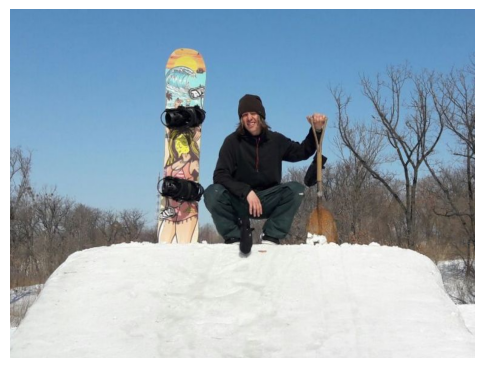

Resized image (512, 640, 3)


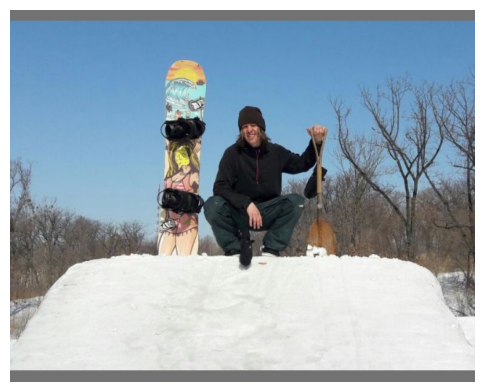

In [ ]:
# read original image
orig_img = read_image('img0.jpg')
print('Original image', orig_img.shape)
show_image(orig_img)

# resize and pad
img = letterbox(orig_img, 640, stride=64, auto=True)[0]
print('Resized image', img.shape)
show_image(img)

Далее картинка преобразуется к `torch.Tensor` и делается вложенной в массив.

In [ ]:
# transform to tensor
img_ = transforms.ToTensor()(img)
print('Transformed to tensor image:', img_.shape)
# add dimension
img_ = torch.unsqueeze(img_, 0)
print('Batch with only one image  :', img_.shape)
# send the picture to the calculating device
img_ = img_.to(device).float()

Transformed to tensor image: torch.Size([3, 512, 640])
Batch with only one image  : torch.Size([1, 3, 512, 640])


Подаём картинку на вход модели. На выходе получаем тензор с результатами детекции на множестве прямоугольников в каждом узле сетки, сгенерированной моделью yolo. Таких сеток несколько, с разным шагом `stride`. И в каждом узле вычисление производится в прямоугольниках нескольких размеров, они также называются якорями `anchors`.

In [ ]:
print('Anchors:', model.yaml['anchors'])

Anchors: [[19, 27, 44, 40, 38, 94], [96, 68, 86, 152, 180, 137], [140, 301, 303, 264, 238, 542], [436, 615, 739, 380, 925, 792]]


Каждый вложенный массив - это пары размеров таких прямоугольников (w, h) для детекции на якоре, здесь по три пары. Индексы вложенных массивов `anchors` соответствуют следующим значениям страйдов `[8, 16, 32, 64]`. Детекция производится на сетках с этими шагами.
Таким образом, для нашей картинки размером `(512, 640)` модель сгенерирует 4 сетки c размерами: `(512/s, 640/s)`, где s - величина страйда
Итого $5120 + 1280 + 320 + 80 = 6800$ узлов во всех сетках. Умножая это значение на количество якорей для каждой сетки получаем: $6800 \cdot 3 = 20400$ прямоугольников-кандидатов.
Действительно, посмотрим на размер предиктов.

In [ ]:
with torch.no_grad():
    pred, _ = model(img_)
print(pred.shape)
pred[0,0]

torch.Size([1, 20400, 57])


tensor([ 5.93158e+00,  3.76684e+00,  1.22991e+01,  1.76533e+01,  1.75282e-07,  9.82455e-01,  3.44554e+00, -4.58328e+00,  8.87518e-02,  5.20410e+00, -9.66386e+00,  1.96930e-01,  1.97590e+00, -5.60032e+00,  1.11285e-01,  7.80209e+00, -7.16559e+00,  1.27019e-01,  1.44117e+00, -5.30032e+00,  2.50809e-01,  1.25499e+01,
         2.39884e+00,  3.10825e-01, -2.74298e+00,  2.05987e+00,  3.03602e-01,  1.77148e+01,  9.63021e+00,  1.65369e-01, -8.31450e+00,  6.66915e+00,  1.59882e-01,  1.51892e+01,  4.66281e+00,  1.50023e-01, -1.56615e+00,  4.54179e+00,  1.48389e-01,  9.25236e+00,  1.87035e+01,  1.49341e-01,  3.07668e-01,  1.88488e+01,
         1.48817e-01,  6.24473e+00,  2.01503e+01,  1.12189e-01, -7.69353e-01,  1.99256e+01,  1.07653e-01,  5.41106e+00,  3.24345e+01,  1.36653e-01, -2.06161e+00,  2.78826e+01,  1.36500e-01], device='cuda:0')

Для каждого прямоугольника-кандидата модель выдаёт 57 значений:
- Первые 6: `[0..3]` - xyxy bbox найденного человека, `4` - conf вероятность предсказанного класса, `5` - метка класса,
- Остальные тройки значений: `x, y, conf, x, y, conf, ...` - координаты точки скелета, вероятность

Среди этих предиктов лишь часть имеют значимую вероятность, для их фильрации используется функция `non_max_suppression_kpt`
Фильтрация в ней происходит в два этапа, сначала по пороговому значению для вероятности детекции человека `conf_thres`, затем оставшиеся значения фильтруются по взвешенному среднему `iou_thres` для вероятностей детекции точек скелета

In [ ]:
pred = non_max_suppression_kpt(pred,
                               conf_thres=0.25,
                               iou_thres=0.65,
                               nc=model.yaml['nc'],
                               nkpt=model.yaml['nkpt'],
                               kpt_label=True)
print(pred[0].shape)

torch.Size([1, 57])


Далее функцией `output_to_keypoint` предикты преобразуются к следующему списку, содержащему оставшиеся рраспознанные позы.
На каждую массив из 58 значений, содержащий номер батча, метку класса, bbox, вероятность, координаты ключевых точек скелета и их вероятности:
По индексам:
```python
[                               # idx - matching
    batch_id, class_id,         # 0, 1 (class_id always = 0 in pose estimation task)
    c_x, c_y, w, h, conf        # 2, 3, 4, 5 - bbox of person; 6 - person detection confidence
    kpt_x, kpt_y, kpt_conf,     # rest of values
    ...
]
```

Выведем результат

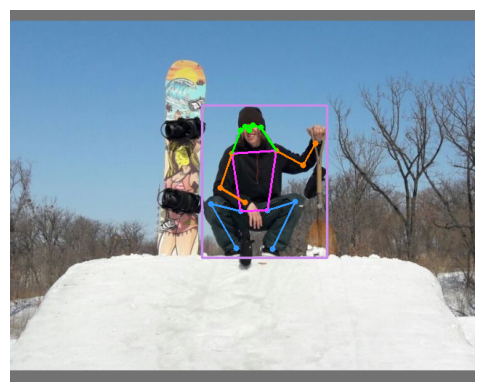

In [ ]:
pred = output_to_keypoint(pred)
plot_pose_prediction(img, pred)
show_image(img)

### Инференс

Оформим все описанные шаги в скрипт `make_pose_prediction`
Реализуем также перевод предсказанных координат к системе координат исходного изображения

In [ ]:
def scale_pose_output(output, resized_shape:tuple, original_shape:tuple, is_padded:bool=True):
    ''' Scale yolo pose estimator output coordinates of bbox and keypoints
    from `resized_shape` to `original_shape`
    '''
    scaled_output = output.copy()
    scale_ratio = resized_shape[1] / original_shape[1], resized_shape[0] / original_shape[0]
    if is_padded:
        # remove padding
        pad_scale = min(scale_ratio)
        padding = ( resized_shape[1] - original_shape[1] * pad_scale ) / 2, (
                    resized_shape[0] - original_shape[0] * pad_scale ) / 2
        scale_ratio = (pad_scale, pad_scale)

        scaled_output[:, 2] -= padding[0]     # x_c unpadding
        scaled_output[:, 3] -= padding[1]     # y_c unpadding
        scaled_output[:, 7::3] -= padding[0]  # x_kpts unpadding
        scaled_output[:, 8::3] -= padding[1]  # y_kpts unpadding

    scaled_output[:, [2, 4]] /= scale_ratio[0]
    scaled_output[:, [3, 5]] /= scale_ratio[1]
    scaled_output[:, 7::3] /= scale_ratio[0]
    scaled_output[:, 8::3] /= scale_ratio[1]

    return scaled_output

def make_pose_prediction(model, img:cv2.Mat) -> list:
    ''' Make prediction with pretrained yolo pose estimator `model` on image `img`
    '''
    # Resize and pad image while meeting stride-multiple constraints
    img_ = letterbox(img, 960, stride=64, auto=True)[0]
    resized_shape = img_.shape[0:2]
    # Transform image to model readable structure
    img_ = transforms.ToTensor()(img_)
    img_ = torch.tensor(np.array([img_.numpy()]))
    img_ = img_.to(device).float()
    with torch.no_grad():
        output, _ = model(img_)
    # Filter predictions
    output = non_max_suppression_kpt(output, 0.25, 0.65,
                                     nc=model.yaml['nc'],
                                     nkpt=model.yaml['nkpt'],
                                     kpt_label=True)
    output = output_to_keypoint(output)
    # scale to original image shape
    output = scale_pose_output(output, resized_shape, img.shape[0:2])
    return output

Отобразим ключевые точки датасета COCO

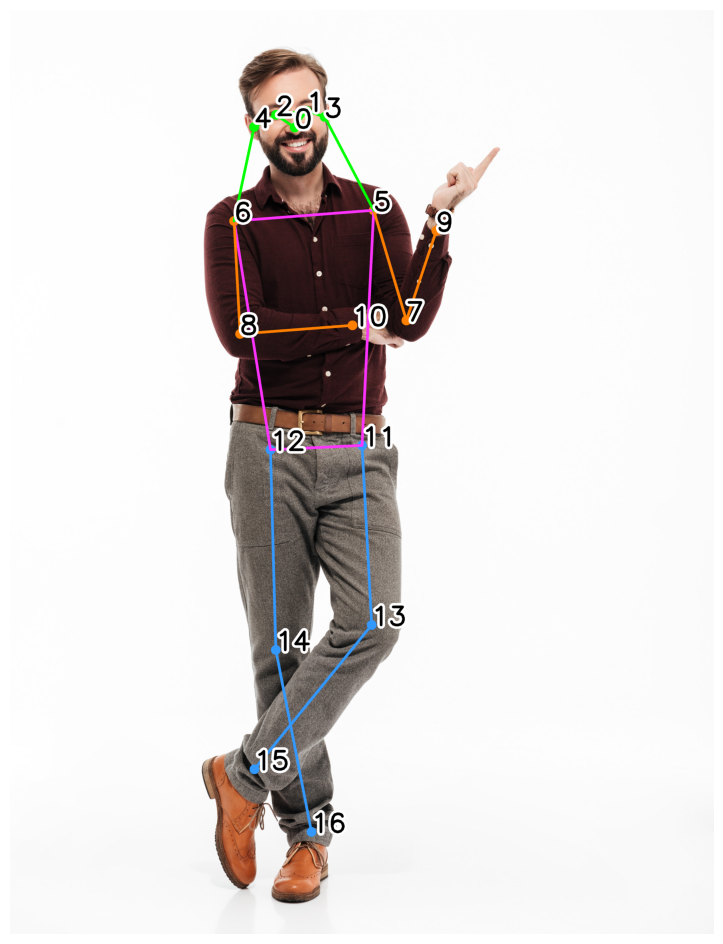

In [ ]:
# reading the image
img = read_image('happy-man.jpg')
# inference
pred = make_pose_prediction(model, img)
# add skeleton to original image
t = max(1, int(pred[0][4]/120))
plot_pose_prediction(img, pred, t, show_bbox=False)
# just for illustration
plot_kpts_numbers(img, pred[0, 7:].T, scale=6, thickness=18)
# show result
show_image(img, (12,12))

|kpt_idx|output_idx| matching                     | comment |
|----|-------------|------------------------      |---------|
|    |`0,1`        | `batch_id, class_id`         | class_id always = 0 |
|    |`2,3, 4,5, 6`| `c_x,c_y, w,h, conf`         | person bbox, detection confidence |
| 0  |`7,8, 9`     | `nose_x,nose_y, nose_conf`   | nose |
| 1  |`10,11, 12`  | `eye_l_x,eye_l_y, eye_l_conf`| left  eye |
| 2  |`13,14, 15`  | `eye_r_x,eye_r_y, eye_r_conf`| right eye |
| 3  |`16,17, 18`  | `ear_l_x,ear_l_y, ear_l_conf`| left  ear |
| 4  |`19,20, 21`  | `ear_r_x,ear_r_y, ear_r_conf`| right ear |
| 5  |`22,23, 24`  | `shldr_l_x,shldr_l_y, shldr_l_conf`| left  shoulder |
| 6  |`25,26, 27`  | `shldr_r_x,shldr_r_y, shldr_r_conf`| right shoulder |
| 7  |`28,29, 30`  | `elbow_l_x,elbow_l_y, elbow_l_conf`| left  elbow |
| 8  |`31,32, 33`  | `elbow_r_x,elbow_r_y, elbow_r_conf`| right elbow |
| 9  |`34,35, 36`  | `wrist_l_x,wrist_l_y, wrist_l_conf`| left  wrist |
| 10 |`37,38, 39`  | `wrist_r_x,wrist_r_y, wrist_r_conf`| right wrist |
| 11 |`40,41, 42`  | `hip_l_x,hip_l_y, hip_l_conf`   | left  hip |
| 12 |`43,44, 45`  | `hip_r_x,hip_r_y, hip_r_conf`   | right hip |
| 13 |`46,47, 48`  | `knee_l_x,knee_l_y, knee_l_conf`| left  knee |
| 14 |`49,50, 51`  | `knee_r_x,knee_r_y, knee_r_conf`| right knee |
| 15 |`52,53, 54`  | `ankle_l_x,ankle_l_y, ankle_l_conf`| left  ankle |
| 16 |`55,56, 57`  | `ankle_r_x,ankle_r_y, ankle_r_conf`| right ankle |

### Пример

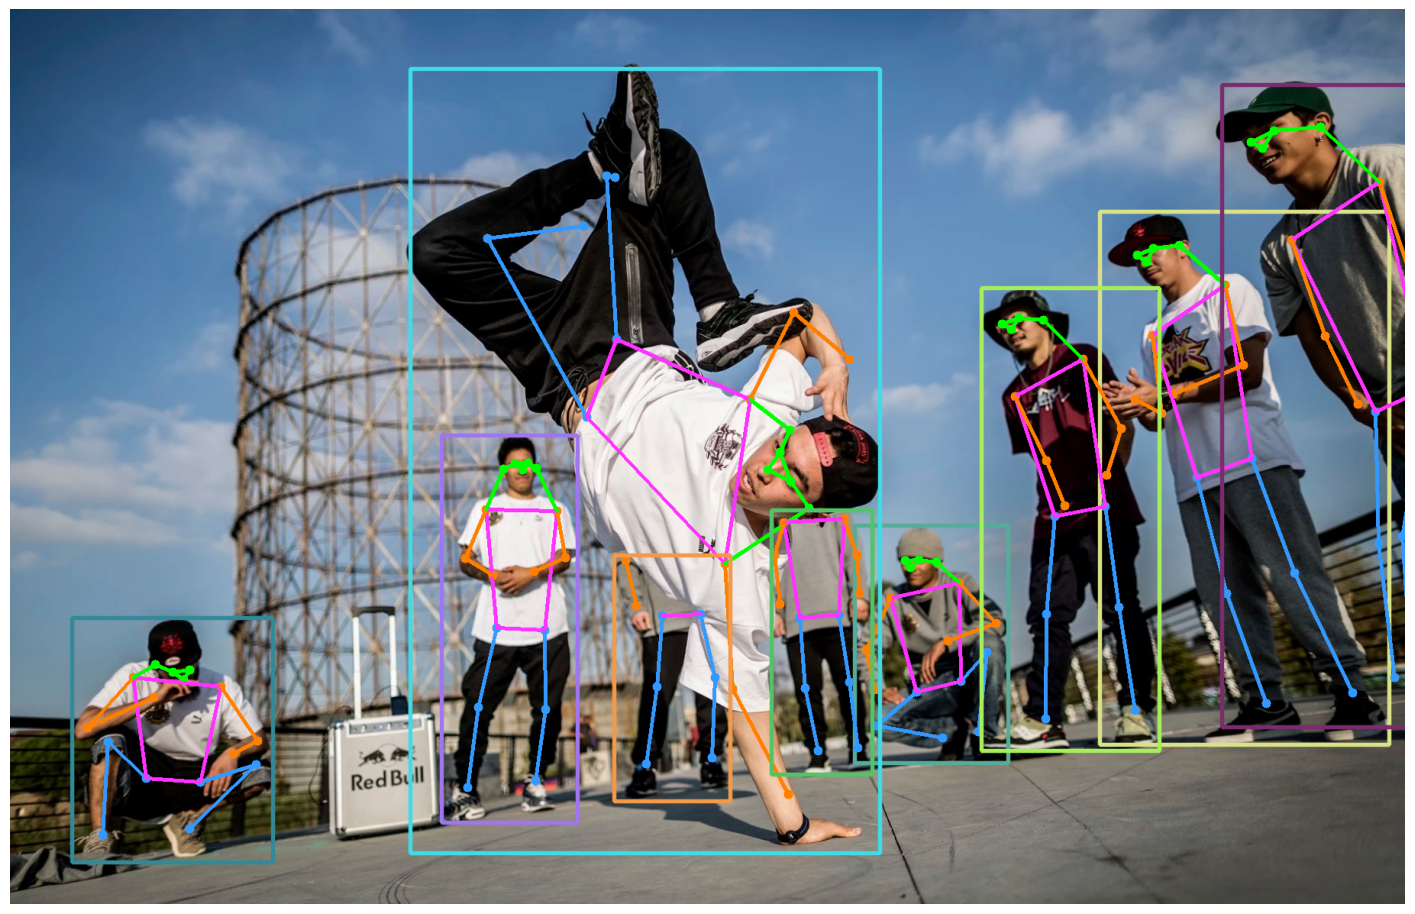

In [ ]:
img = read_image('breakdance.jpg')
pred = make_pose_prediction(model, img)
plot_pose_prediction(img, pred, 3)
show_image(img, (18,18))

# Обработка видео

In [ ]:
from google.colab.patches import cv2_imshow

def video_pred(filename, out_filename):
    # Open the input video file and extract its properties
    cap = cv2.VideoCapture(filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(out_filename, fourcc, fps, (width, height))
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            pred = make_pose_prediction(model, frame)
            plot_pose_prediction(frame, pred, show_bbox=False)
            out.write(frame)
            cv2_imshow(frame)
        else:
            break

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
!python video.py -i path/to/original_video.mp4 -o path/to/processed_video.mp4

Selected Device :  cuda:0
Fusing layers... 
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
video_pred('test_video/1persondance.mp4', 'res_video/1persondance_out.mp4')

In [ ]:
video_pred('test_video/6persondance.mp4', 'res_video/6persondance_out.mp4')

# Скорость работы модели

In [ ]:
def pose_estimation_video(filename, out_filename):
    # Open the input video file and extract its properties
    cap = cv2.VideoCapture(filename)
    tot = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    i = 0.
    while cap.isOpened():
        print(f"Processing: {i/tot:.1%}", end='\r' )
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pred = make_pose_prediction(model, frame)
        else:
            break
        i += 1.
    cap.release()

In [ ]:
%%time
pose_estimation_video('1persondance.mp4', '1persondance_out.mp4')


CPU times: user 1.15 ms, sys: 0 ns, total: 1.15 ms
Wall time: 1.27 ms


In [ ]:
%%time
pose_estimation_video('6persondance.mp4', '6persondance_out.mp4')

CPU times: user 1.17 ms, sys: 23 µs, total: 1.2 ms
Wall time: 1.38 ms


# Тестирование на coco.kpts

In [43]:
!python test.py --data data/coco_kpts.yaml --img 640 --conf 0.001 --iou 0.65 --weights yolov7-w6-pose.pt --kpt-label

Namespace(weights=['yolov7-w6-pose.pt'], data='data/coco_kpts.yaml', batch_size=32, img_size=640, conf_thres=0.001, iou_thres=0.65, task='val', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_txt_tidl=False, tidl_load=False, dump_img=False, save_hybrid=False, save_conf=False, save_json=False, save_json_kpt=True, project='runs/test', name='exp', exist_ok=False, kpt_label=True, flip_test=False)
YOLOR 🚀 v0.1-126-g84932d7 torch 2.0.1+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 494 layers, 80178356 parameters, 80178356 gradients, 101.6 GFLOPS
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:831: UserWarning: